In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the Repeat-Vector model

In [2]:
# decoder input: original time series value at last time step

class RepeatVector(object):

    def __init__(self, hidden_num, inputs, optimizer=None, reverse=True,):
        # inputs is a list with length step_num.
        # each element in inputs has size (batch_num,elem_num)
        
        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
 

        self._enc_cell = tf.nn.rnn_cell.LSTMCell(hidden_num,use_peepholes=True)
        self._dec_cell = tf.nn.rnn_cell.LSTMCell(hidden_num,use_peepholes=True)

        
        
        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)
            
        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            #Repeat vector
            dec_inputs = [self.z_codes[-1] for _ in range(len(self.z_codes))]

            (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)
            
            if reverse:
                dec_outputs = dec_outputs[::-1]

            dec_output_ = tf.transpose(tf.stack(dec_outputs), [1,0,2])
            dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
            self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_

        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))
   
        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load Power Demand Dataset

In [3]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/preprocessed/PowerDemand/6_subsets/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [4]:
tf.reset_default_graph()

batch_num = 3

hidden_num = 40

step_num = 84

elem_num = sn.shape[1]

iteration = 5000

modlepath = "C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_powerdemand_v1.ckpt"

In [5]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t6)]


In [6]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]
#squeeze: remove [1]dim
#split: split p_input into step_num tensors along dim 1.
# so for t in tf.split(p_input, step_num, 1), t has size (batch_num,1,elem_num)
# and each element in p_inputs has shape(batch_num,elem_num), totally step_num elements


In [7]:
ae = RepeatVector(hidden_num, p_inputs)

# Training

iter 1: 0.153093
iter 2: 0.099436
iter 3: 0.0495519
iter 4: 0.0471296
iter 5: 0.0501203
iter 6: 0.0598686
iter 7: 0.0644219
iter 8: 0.0516917
iter 9: 0.0459112
iter 10: 0.0403425
iter 11: 0.0383982
iter 12: 0.0408919
iter 13: 0.0431826
iter 14: 0.0409212
iter 15: 0.0499298
iter 16: 0.049295
iter 17: 0.0450283
iter 18: 0.0407096
iter 19: 0.047105
iter 20: 0.038134
iter 21: 0.0329189
iter 22: 0.0356133
iter 23: 0.0444979
iter 24: 0.0414488
iter 25: 0.0417037
iter 26: 0.0395525
iter 27: 0.043822
iter 28: 0.0400204
iter 29: 0.0347882
iter 30: 0.0426105
iter 31: 0.0416548
iter 32: 0.0362956
iter 33: 0.0332092
iter 34: 0.0341855
iter 35: 0.0432637
iter 36: 0.0414104
iter 37: 0.0342512
iter 38: 0.0367247
iter 39: 0.0394546
iter 40: 0.0402968
iter 41: 0.0349475
iter 42: 0.0367458
iter 43: 0.0408853
iter 44: 0.033943
iter 45: 0.0405909
iter 46: 0.0327636
iter 47: 0.0381539
iter 48: 0.0314559
iter 49: 0.0419614
iter 50: 0.0293705
iter 51: 0.0383889
iter 52: 0.0345744
iter 53: 0.0267543
iter 54: 

iter 422: 0.0262086
iter 423: 0.0319727
iter 424: 0.0339148
iter 425: 0.0284156
iter 426: 0.0308856
iter 427: 0.0353217
iter 428: 0.0343758
iter 429: 0.0339387
iter 430: 0.0349991
iter 431: 0.0339376
iter 432: 0.0312849
iter 433: 0.0300868
iter 434: 0.028839
iter 435: 0.0316982
iter 436: 0.0315236
iter 437: 0.0359461
iter 438: 0.0309342
iter 439: 0.0285395
iter 440: 0.036529
iter 441: 0.0285512
iter 442: 0.0307902
iter 443: 0.0298763
iter 444: 0.0250728
iter 445: 0.0502226
iter 446: 0.0338574
iter 447: 0.0318182
iter 448: 0.0362535
iter 449: 0.0347851
iter 450: 0.0336464
iter 451: 0.0303738
iter 452: 0.0367679
iter 453: 0.0358643
iter 454: 0.0313107
iter 455: 0.0298533
iter 456: 0.0400539
iter 457: 0.0305948
iter 458: 0.0342102
iter 459: 0.0320386
iter 460: 0.0368378
iter 461: 0.0382922
iter 462: 0.0338901
iter 463: 0.0295222
iter 464: 0.0392363
iter 465: 0.030555
iter 466: 0.0327734
iter 467: 0.032155
iter 468: 0.0322881
iter 469: 0.0315687
iter 470: 0.030571
iter 471: 0.0304785
iter 

iter 826: 0.00566285
iter 827: 0.00483972
iter 828: 0.00547659
iter 829: 0.00446312
iter 830: 0.00479344
iter 831: 0.00544633
iter 832: 0.00579101
iter 833: 0.00482948
iter 834: 0.00369362
iter 835: 0.00468814
iter 836: 0.00448966
iter 837: 0.00671628
iter 838: 0.00463152
iter 839: 0.00458597
iter 840: 0.004431
iter 841: 0.00458337
iter 842: 0.00608275
iter 843: 0.00424951
iter 844: 0.00365805
iter 845: 0.00461678
iter 846: 0.00402723
iter 847: 0.00472925
iter 848: 0.00392627
iter 849: 0.00529763
iter 850: 0.00407046
iter 851: 0.00607473
iter 852: 0.0038468
iter 853: 0.00476271
iter 854: 0.00514946
iter 855: 0.00415851
iter 856: 0.00494373
iter 857: 0.00436203
iter 858: 0.00440662
iter 859: 0.00596947
iter 860: 0.00348472
iter 861: 0.00500282
iter 862: 0.00494278
iter 863: 0.00465917
iter 864: 0.00536565
iter 865: 0.00491587
iter 866: 0.00438439
iter 867: 0.00463097
iter 868: 0.00512112
iter 869: 0.00354578
iter 870: 0.00463914
iter 871: 0.00474465
iter 872: 0.00450751
iter 873: 0.0047

iter 1208: 0.0060978
iter 1209: 0.00447496
iter 1210: 0.00490811
iter 1211: 0.00545495
iter 1212: 0.00548803
iter 1213: 0.00426444
iter 1214: 0.00371186
iter 1215: 0.0053401
iter 1216: 0.00393712
iter 1217: 0.00426832
iter 1218: 0.00518729
iter 1219: 0.0036975
iter 1220: 0.00436784
iter 1221: 0.0041548
iter 1222: 0.00610676
iter 1223: 0.00395424
iter 1224: 0.00459764
iter 1225: 0.00464222
iter 1226: 0.0049316
iter 1227: 0.00532315
iter 1228: 0.00453743
iter 1229: 0.00502806
iter 1230: 0.00436737
iter 1231: 0.00531849
iter 1232: 0.00544728
iter 1233: 0.00467322
iter 1234: 0.00353294
iter 1235: 0.00489814
iter 1236: 0.00425495
iter 1237: 0.00405859
iter 1238: 0.00635266
iter 1239: 0.00418899
iter 1240: 0.00363716
iter 1241: 0.00318494
iter 1242: 0.00387506
iter 1243: 0.00422635
iter 1244: 0.00392189
iter 1245: 0.00556862
iter 1246: 0.00389525
iter 1247: 0.00472074
iter 1248: 0.00354297
iter 1249: 0.00328986
iter 1250: 0.00507763
iter 1251: 0.00362654
iter 1252: 0.00367314
iter 1253: 0.00

iter 1586: 0.0047397
iter 1587: 0.00470078
iter 1588: 0.00395086
iter 1589: 0.00310912
iter 1590: 0.00288009
iter 1591: 0.00324219
iter 1592: 0.00442376
iter 1593: 0.0029732
iter 1594: 0.00451597
iter 1595: 0.00470942
iter 1596: 0.00482957
iter 1597: 0.00394928
iter 1598: 0.00412695
iter 1599: 0.00387142
iter 1600: 0.0033764
iter 1601: 0.00308594
iter 1602: 0.00447494
iter 1603: 0.00358689
iter 1604: 0.00345332
iter 1605: 0.00363227
iter 1606: 0.00411065
iter 1607: 0.00385043
iter 1608: 0.00317051
iter 1609: 0.00465988
iter 1610: 0.0036583
iter 1611: 0.0037438
iter 1612: 0.00380832
iter 1613: 0.00485152
iter 1614: 0.00439586
iter 1615: 0.00325446
iter 1616: 0.00397718
iter 1617: 0.00471964
iter 1618: 0.0040935
iter 1619: 0.00302072
iter 1620: 0.00376724
iter 1621: 0.00371739
iter 1622: 0.00432911
iter 1623: 0.00405927
iter 1624: 0.00360289
iter 1625: 0.00436543
iter 1626: 0.00310433
iter 1627: 0.00324983
iter 1628: 0.00404064
iter 1629: 0.0038832
iter 1630: 0.00459089
iter 1631: 0.0045

iter 1964: 0.0044588
iter 1965: 0.00388065
iter 1966: 0.00445811
iter 1967: 0.0045456
iter 1968: 0.00404711
iter 1969: 0.00403452
iter 1970: 0.00408707
iter 1971: 0.00466813
iter 1972: 0.00351227
iter 1973: 0.00472522
iter 1974: 0.00388766
iter 1975: 0.00440723
iter 1976: 0.00407919
iter 1977: 0.0045921
iter 1978: 0.00350329
iter 1979: 0.00337306
iter 1980: 0.00407691
iter 1981: 0.00357977
iter 1982: 0.00487717
iter 1983: 0.00300888
iter 1984: 0.00379007
iter 1985: 0.00376853
iter 1986: 0.00426027
iter 1987: 0.00509168
iter 1988: 0.00354686
iter 1989: 0.00350546
iter 1990: 0.00335501
iter 1991: 0.0028304
iter 1992: 0.00384622
iter 1993: 0.0052135
iter 1994: 0.00352541
iter 1995: 0.00357888
iter 1996: 0.00331579
iter 1997: 0.00487175
iter 1998: 0.00372436
iter 1999: 0.00312723
iter 2000: 0.00546296
iter 2001: 0.0038601
iter 2002: 0.00288834
iter 2003: 0.005304
iter 2004: 0.00372207
iter 2005: 0.00463259
iter 2006: 0.00390112
iter 2007: 0.00416489
iter 2008: 0.00321434
iter 2009: 0.00308

iter 2341: 0.00395846
iter 2342: 0.00257711
iter 2343: 0.00348496
iter 2344: 0.00568828
iter 2345: 0.00311517
iter 2346: 0.00303405
iter 2347: 0.00448568
iter 2348: 0.00367549
iter 2349: 0.00415485
iter 2350: 0.00355701
iter 2351: 0.00353884
iter 2352: 0.00335556
iter 2353: 0.00446069
iter 2354: 0.0036299
iter 2355: 0.00350821
iter 2356: 0.00320927
iter 2357: 0.00416271
iter 2358: 0.00536592
iter 2359: 0.00387466
iter 2360: 0.00281259
iter 2361: 0.00391027
iter 2362: 0.00404957
iter 2363: 0.00314064
iter 2364: 0.00414897
iter 2365: 0.00435038
iter 2366: 0.00352767
iter 2367: 0.00385728
iter 2368: 0.00343396
iter 2369: 0.0051522
iter 2370: 0.00347984
iter 2371: 0.00297513
iter 2372: 0.00474453
iter 2373: 0.00339168
iter 2374: 0.00299102
iter 2375: 0.00465019
iter 2376: 0.00362271
iter 2377: 0.0035698
iter 2378: 0.00354218
iter 2379: 0.00381132
iter 2380: 0.00351507
iter 2381: 0.00301926
iter 2382: 0.00313313
iter 2383: 0.00345327
iter 2384: 0.00327483
iter 2385: 0.00406945
iter 2386: 0.

iter 2718: 0.00246808
iter 2719: 0.00341695
iter 2720: 0.00360444
iter 2721: 0.00358229
iter 2722: 0.00443351
iter 2723: 0.00434355
iter 2724: 0.0030656
iter 2725: 0.0025265
iter 2726: 0.00306153
iter 2727: 0.0036533
iter 2728: 0.00346576
iter 2729: 0.00312507
iter 2730: 0.00297965
iter 2731: 0.00341521
iter 2732: 0.00412516
iter 2733: 0.00292364
iter 2734: 0.00309251
iter 2735: 0.00281833
iter 2736: 0.00276605
iter 2737: 0.00289217
iter 2738: 0.00258481
iter 2739: 0.00233449
iter 2740: 0.00313356
iter 2741: 0.00307309
iter 2742: 0.00337953
iter 2743: 0.00306585
iter 2744: 0.00330937
iter 2745: 0.00229366
iter 2746: 0.00285515
iter 2747: 0.00391603
iter 2748: 0.00321806
iter 2749: 0.00262565
iter 2750: 0.00365838
iter 2751: 0.00285841
iter 2752: 0.00237792
iter 2753: 0.00299324
iter 2754: 0.00341265
iter 2755: 0.00377284
iter 2756: 0.00280724
iter 2757: 0.00325557
iter 2758: 0.00298759
iter 2759: 0.0026842
iter 2760: 0.0036065
iter 2761: 0.00268792
iter 2762: 0.00254223
iter 2763: 0.00

iter 3095: 0.00265841
iter 3096: 0.00365147
iter 3097: 0.00259151
iter 3098: 0.00321933
iter 3099: 0.00284137
iter 3100: 0.00336038
iter 3101: 0.00299269
iter 3102: 0.00376569
iter 3103: 0.00439246
iter 3104: 0.00366251
iter 3105: 0.0030291
iter 3106: 0.00296839
iter 3107: 0.00313668
iter 3108: 0.00256733
iter 3109: 0.00256786
iter 3110: 0.00449433
iter 3111: 0.00308777
iter 3112: 0.00283558
iter 3113: 0.00310656
iter 3114: 0.00291222
iter 3115: 0.00432175
iter 3116: 0.00291673
iter 3117: 0.00328972
iter 3118: 0.00275296
iter 3119: 0.00311575
iter 3120: 0.00290636
iter 3121: 0.0032487
iter 3122: 0.00305882
iter 3123: 0.00273557
iter 3124: 0.00260922
iter 3125: 0.00320381
iter 3126: 0.00227298
iter 3127: 0.00216444
iter 3128: 0.00249008
iter 3129: 0.00320751
iter 3130: 0.00325307
iter 3131: 0.00365638
iter 3132: 0.00344017
iter 3133: 0.0033269
iter 3134: 0.0025606
iter 3135: 0.00249723
iter 3136: 0.00431622
iter 3137: 0.00371605
iter 3138: 0.00286791
iter 3139: 0.00294631
iter 3140: 0.0

iter 3469: 0.00263796
iter 3470: 0.00264921
iter 3471: 0.00255159
iter 3472: 0.00211435
iter 3473: 0.00235999
iter 3474: 0.00301796
iter 3475: 0.00231007
iter 3476: 0.00258615
iter 3477: 0.0026204
iter 3478: 0.00301773
iter 3479: 0.00239164
iter 3480: 0.00180786
iter 3481: 0.00266936
iter 3482: 0.00264853
iter 3483: 0.00251047
iter 3484: 0.00177121
iter 3485: 0.0032115
iter 3486: 0.00252918
iter 3487: 0.00327461
iter 3488: 0.00201101
iter 3489: 0.0025291
iter 3490: 0.00185644
iter 3491: 0.00253618
iter 3492: 0.0021366
iter 3493: 0.00178307
iter 3494: 0.00196284
iter 3495: 0.00242951
iter 3496: 0.00302637
iter 3497: 0.00266713
iter 3498: 0.0020854
iter 3499: 0.00223485
iter 3500: 0.00219591
iter 3501: 0.00327034
iter 3502: 0.00200457
iter 3503: 0.00218576
iter 3504: 0.00195575
iter 3505: 0.00195918
iter 3506: 0.00272013
iter 3507: 0.00206241
iter 3508: 0.00162174
iter 3509: 0.00175749
iter 3510: 0.00207086
iter 3511: 0.0014626
iter 3512: 0.00325976
iter 3513: 0.00195127
iter 3514: 0.002

iter 3849: 0.00255956
iter 3850: 0.00213994
iter 3851: 0.00220291
iter 3852: 0.00260199
iter 3853: 0.00203676
iter 3854: 0.00168776
iter 3855: 0.00207129
iter 3856: 0.00201669
iter 3857: 0.00225533
iter 3858: 0.00182889
iter 3859: 0.00275443
iter 3860: 0.00185207
iter 3861: 0.00230714
iter 3862: 0.0019977
iter 3863: 0.00209542
iter 3864: 0.00154488
iter 3865: 0.00314524
iter 3866: 0.00302744
iter 3867: 0.00244636
iter 3868: 0.00146598
iter 3869: 0.0024223
iter 3870: 0.00228304
iter 3871: 0.00189447
iter 3872: 0.00234637
iter 3873: 0.00191382
iter 3874: 0.00176619
iter 3875: 0.00244717
iter 3876: 0.00153813
iter 3877: 0.00149567
iter 3878: 0.00180014
iter 3879: 0.00152815
iter 3880: 0.00201166
iter 3881: 0.00236156
iter 3882: 0.00156876
iter 3883: 0.00155167
iter 3884: 0.00160344
iter 3885: 0.00146223
iter 3886: 0.00156553
iter 3887: 0.00181312
iter 3888: 0.00174748
iter 3889: 0.00192446
iter 3890: 0.00167077
iter 3891: 0.00229153
iter 3892: 0.00219693
iter 3893: 0.00219039
iter 3894: 0

iter 4225: 0.00212221
iter 4226: 0.00170413
iter 4227: 0.00151217
iter 4228: 0.00180835
iter 4229: 0.00223411
iter 4230: 0.00243452
iter 4231: 0.00169097
iter 4232: 0.00225153
iter 4233: 0.0015435
iter 4234: 0.0016667
iter 4235: 0.00223495
iter 4236: 0.00141984
iter 4237: 0.00273394
iter 4238: 0.00213454
iter 4239: 0.0023106
iter 4240: 0.00175799
iter 4241: 0.00290894
iter 4242: 0.00132804
iter 4243: 0.00225049
iter 4244: 0.00154384
iter 4245: 0.0024578
iter 4246: 0.0024691
iter 4247: 0.00161581
iter 4248: 0.00194659
iter 4249: 0.00267967
iter 4250: 0.00232506
iter 4251: 0.0016902
iter 4252: 0.00311489
iter 4253: 0.00268934
iter 4254: 0.00165154
iter 4255: 0.00332704
iter 4256: 0.00163067
iter 4257: 0.0025124
iter 4258: 0.00134664
iter 4259: 0.00252061
iter 4260: 0.00172947
iter 4261: 0.00169731
iter 4262: 0.00210114
iter 4263: 0.00141345
iter 4264: 0.00224169
iter 4265: 0.00165077
iter 4266: 0.00301657
iter 4267: 0.00166488
iter 4268: 0.00154428
iter 4269: 0.00230982
iter 4270: 0.0020

iter 4600: 0.00171351
iter 4601: 0.00131036
iter 4602: 0.00175534
iter 4603: 0.00185687
iter 4604: 0.00179823
iter 4605: 0.00122828
iter 4606: 0.00153598
iter 4607: 0.00158261
iter 4608: 0.00137699
iter 4609: 0.00248734
iter 4610: 0.0013069
iter 4611: 0.00193273
iter 4612: 0.00137573
iter 4613: 0.001538
iter 4614: 0.00127148
iter 4615: 0.0015076
iter 4616: 0.00163881
iter 4617: 0.00119079
iter 4618: 0.00158807
iter 4619: 0.00222136
iter 4620: 0.00182029
iter 4621: 0.00228559
iter 4622: 0.00228849
iter 4623: 0.00161762
iter 4624: 0.001445
iter 4625: 0.00166279
iter 4626: 0.00163852
iter 4627: 0.00259782
iter 4628: 0.00149241
iter 4629: 0.00222121
iter 4630: 0.00174877
iter 4631: 0.00190116
iter 4632: 0.0011543
iter 4633: 0.00204382
iter 4634: 0.00165664
iter 4635: 0.00199514
iter 4636: 0.0015233
iter 4637: 0.00150634
iter 4638: 0.00133886
iter 4639: 0.00165116
iter 4640: 0.00157162
iter 4641: 0.00173375
iter 4642: 0.0020107
iter 4643: 0.00133931
iter 4644: 0.00166688
iter 4645: 0.001269

iter 4975: 0.00112667
iter 4976: 0.00116668
iter 4977: 0.00156842
iter 4978: 0.0011787
iter 4979: 0.00167258
iter 4980: 0.00117406
iter 4981: 0.00167507
iter 4982: 0.00123785
iter 4983: 0.00211247
iter 4984: 0.00142127
iter 4985: 0.001357
iter 4986: 0.00156697
iter 4987: 0.000960822
iter 4988: 0.00154965
iter 4989: 0.00135191
iter 4990: 0.00143271
iter 4991: 0.00142282
iter 4992: 0.00183277
iter 4993: 0.00151997
iter 4994: 0.00183905
iter 4995: 0.00152304
iter 4996: 0.0019302
iter 4997: 0.00207151
iter 4998: 0.00138692
iter 4999: 0.0014913
iter 5000: 0.000862654
Model saved in file: C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_powerdemand_v1.ckpt


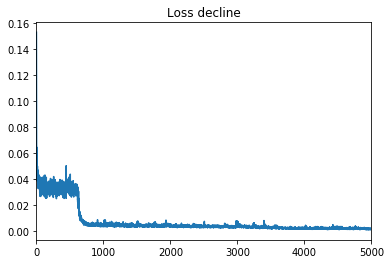

In [8]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss decline")
    save_path = saver.save(sess, modlepath)
    print("Model saved in file: %s" % save_path) 

# Calculate parameters using Vn1 dataset 

In [9]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')

    data = np.array(vn1_list)
    (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})

    err_vec = abs(input_ - output_).reshape(-1,step_num)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_powerdemand_v1.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [10]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Finished')

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_powerdemand_v1.ckpt
Model restored.
Initialized
Finished


In [11]:
# the threshold leads to best f1 sore
def evaluate(threshold):
    beta = 0.5
    tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
    fp = len(abnormal_score)-tp
    fn = np.array(normal_score)[np.array(normal_score)>threshold].size
    tn = len(normal_score)- fn
    P = tp/(tp+fp)
    R = tp/(tp+fn)
    fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
    return fbeta


upper = np.median(np.array(abnormal_score))
lower = np.median(np.array(normal_score)) 
scala = 20
delta = (upper-lower) / scala
candidate = lower
threshold = 0
result = 0

for _ in range(scala):
    r = evaluate(candidate)
    if r > result:
        result = r 
        threshold = candidate
    candidate += delta 

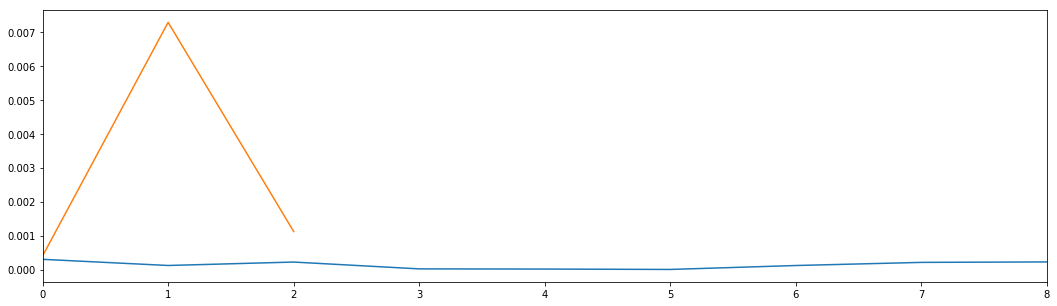

In [12]:
# anomaly score of vn2 and va dataset
pd.Series(normal_score).plot(figsize=(18,5))
pd.Series(abnormal_score).plot()

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_powerdemand_v1.ckpt
Model restored.
Initialized


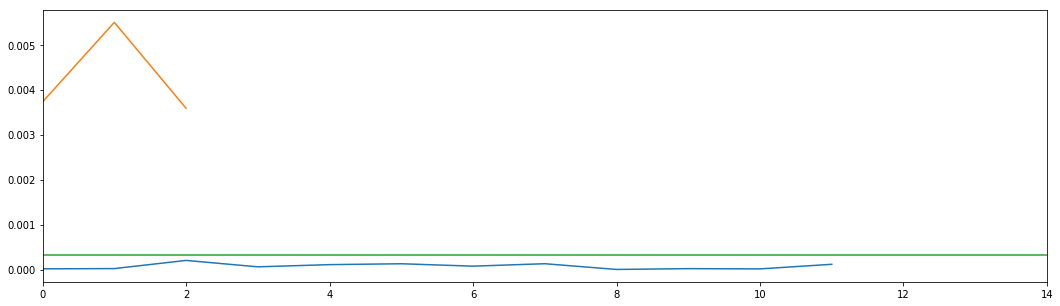

In [13]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

            
    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

# Evaluation

In [14]:
beta = 0.5
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

1.0

In [15]:
print(tp,fp,tn,fn,P,R)

3 0 12 0 1.0 1.0
